<a href="https://colab.research.google.com/github/AranyaAryaman/Portfolio-Optimization/blob/main/Main_program_final_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..
!pip install ta-lib


from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import talib
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras import backend as K
import keras
from keras.models import *
from keras.layers import *
from keras import layers
import time
import timeit
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from statistics import mean
import requests
from datetime import date, timedelta

--2025-12-02 11:45:31--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.13.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-12-02 11:45:31--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://gigenet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2025-12-02 11:45:31--  http://gigenet.dl.source

In [4]:
!pip install PyPortfolioOpt

In [5]:
class Time2Vec(layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__()
        self.k = kernel_size

    def build(self, input_shape):
        time_dim = input_shape[-1]

        # Trend: W * t + b
        self.wb = self.add_weight(
            shape=(time_dim,),
            initializer='uniform',
            trainable=True,
            name="weight_trend"
        )
        self.bb = self.add_weight(
            shape=(time_dim,),
            initializer='uniform',
            trainable=True,
            name="bias_trend"
        )

        # Periodic: sin(W * t + b)
        self.wa = self.add_weight(
            shape=(time_dim, self.k),
            initializer='uniform',
            trainable=True,
            name="weight_periodic"
        )
        self.ba = self.add_weight(
            shape=(self.k,),
            initializer='uniform',
            trainable=True,
            name="bias_periodic"
        )

    def call(self, inputs):
        # Linear term
        trend = inputs * self.wb + self.bb      # (batch, time, features)

        # Periodic term
        dp = tf.tensordot(inputs, self.wa, axes=1) + self.ba  # (batch, time, k)
        periodic = tf.sin(dp)

        # Concatenate
        return tf.concat([trend, periodic], axis=-1)  # (batch, time, features + k)

    def compute_output_shape(self, input_shape):
      if len(input_shape) == 3:
          batch, time_steps, features = input_shape
          return (batch, time_steps, features + self.k)

      # Case: input is (batch, features)
      elif len(input_shape) == 2:
          batch, features = input_shape
          return (batch, features + self.k)

      else:
          raise ValueError(f"Unexpected input shape: {input_shape}")

In [6]:
class ETL:
    """
    This class performs Extract, Transform, and Load (ETL) operations on historical stock data.
    It extracts data for a given stock ticker from Yahoo Finance, splits the data into train, validation and test sets,
    reshapes the data into the required format, and converts the problem into a supervised learning problem.
    """
    def __init__(self, ticker=[], test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        """
        Constructor for the ETL class.

        Parameters:
        - ticker: List of stock tickers.
        - test_size: Fraction of data to be used as the test set.
        - period: Time period for fetching historical data ('max' by default).
        - n_input: Number of input time steps for the supervised learning problem.
        - timestep: Number of time steps used to reshape the data.

        Initializes attributes, fetches historical data, and performs ETL operations.
        """
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)


    def extract_historic_data(self) -> pd.Series:
        """
        Fetches historical stock data using Yahoo Finance API.
        Creates a pandas dataframe with the closing prices of each stock of the portfolio
        """
        # Fetch historical data using yfinance
        start_date = '2010-01-13'
        end_date = '2023-12-26'
        delta = timedelta(days=1)

        # Create an empty DataFrame
        df = pd.DataFrame()

        # Fetch and append closing prices for each stock
        for symbol in self.ticker:
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            df[symbol] = stock_data['Close']

        #updates the database by removing the rows with missing values
        df.dropna(inplace=True)
        return df

    def split_data(self) -> tuple:
        """
        Splits historical data into train and test sets.
        Returns training and test sets as numpy arrays
        """
        #calls self.extract_historic_data() to retrieve historical stock prices of each stock
        data = self.extract_historic_data()

        if len(data) != 0:

            #calculates the number of data points for training set
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]

            #the rest of the data points are used as test data
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:

            #Raises an exception if the dataset is empty
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        which is, [no of samples, timestep, no of assets]
        """
        no_assets = len(self.ticker)
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, no_assets))

    def transform(self, train, test) -> np.array:
        """
        Applies data transformation to test and train sets.
        Returns the transformed test and train sets
        """
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Performs the complete ETL process.
        Returns a tuple which contains train and test sets after ETL.
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def features(self, period, stock_val):
        """
        Extracts additional features from historical stock data.
        Returns a pandas DataFrame with additional features
        """
        df_hist = self.extract_historic_data()
        stock = self.ticker[stock_val]

        df = pd.DataFrame()
        df[stock] = df_hist[stock]

        #uses talib library to calculate Relative Strength Index
        df['RSI'] = talib.RSI(df_hist[stock], timeperiod=period)
        df['MoM'] = df_hist[stock].diff(1)

        #uses talib library to calculate Exponential Moving Average
        df['EMA'] = talib.EMA(df_hist[stock], timeperiod=period)

        #Calculating Rolling averages, 5day, 10day and 20day
        df['5_Day_MA'] = df_hist[stock].rolling(window=5).mean()
        df['10_Day_MA'] = df_hist[stock].rolling(window=10).mean()
        df['20_Day_MA'] = df_hist[stock].rolling(window=20).mean()

        df.dropna(inplace=True)

        return df

    def to_supervised(self, input_data, n_out=5) -> tuple:
        """
        Converts the time series prediction problem to a supervised learning problem.
        Returns the input and output sequences for supervised learning
        """

        stocks = self.ticker
        num_stocks = len(stocks)
        data_x = []
        data_y = []

        for i in range(len(self.ticker)):

            #calculates the number of rows
            num_rows = input_data.shape[0]*input_data.shape[1]

            #generates a value for each stock to distinguish them during training
            stock_ticker_val = np.full((num_rows, 1), i+1)

            #calls the self.features function and computes all the features required for supervised learning
            stock_with_ft = np.array(self.features(period =5, stock_val = i))
            print(stock_with_ft.shape)

            samples = int(stock_with_ft.shape[0] // self.timestep)
            stock_with_ft = stock_with_ft[:samples * self.timestep]
            features = stock_with_ft.reshape((samples, self.timestep, -1))

            feature_array = []

            if (np.array(features).shape[0]/2) > input_data.shape[0]:
                feature_array = np.array(features[-input_data.shape[0]:])
            else:
                feature_array = np.array(features[:input_data.shape[0]])


            #create separate arrays for each feature
            new_array = input_data[:,:, i].reshape((input_data.shape[0]*input_data.shape[1],1))
            rsi = feature_array[:,:,1].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            mom = feature_array[:,:,2].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            ema = feature_array[:,:,3].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            five_day = feature_array[:,:,4].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            ten_day = feature_array[:,:,5].reshape((feature_array.shape[0]*feature_array.shape[1],1))
            twenty_day = feature_array[:,:,6].reshape((feature_array.shape[0]*feature_array.shape[1],1))

            #stacks all the input features together and creates a new numpy array
            reshaped_array = np.hstack((new_array, rsi, five_day, ten_day, twenty_day, stock_ticker_val))


            X, y = [], []
            in_start = 20

            # step over the entire history one time step at a time
            for _ in range(len(reshaped_array)):

                # define the end of the input sequence
                in_end = in_start + self.n_input
                out_end = in_end + n_out

                # ensure we have enough data for this instance
                if out_end <= len(reshaped_array):
                    x_input = reshaped_array[in_start:in_end, :]
                    x_input = x_input.reshape((len(x_input), 6))
                    X.append(x_input)
                    y.append(reshaped_array[in_end:out_end, 0])

                    # move along one time step
                    in_start += 1

            data_x.append(X)
            data_y.append(y)

        data_x = np.array(data_x)
        data_y = np.array(data_y)
        print(data_x.shape)
        return data_x, data_y

In [7]:
class PredictAndForecast():
    """
    This class takes a trained model, train, and test datasets and returns predictions
    of length len(test) with the same shape.
    """
    def __init__(self, model, train, test, n_input=5) -> None:

        """
        Constructor for the PredictAndForecast class.

        Parameters:
        model: Trained TensorFlow/Keras model.
        train: Numpy array representing the training data.
        test: Numpy array representing the testing data.
        n_input: Number of input time steps for forecasting.

        Initializes attributes and computes predictions using the trained model.
        """
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()


    def forecast(self, history) -> np.array:

        """
        Given last week's actual data, forecasts next week's prices.
        """

        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]

        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))

        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        Compiles model predictions week by week over the entire test set.
        Returns an array containing predictions for each week.
        """
        # history is a list of weekly data
        history = [x for x in self.train]

        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)

            # store the predictions
            predictions.append(yhat_sequence)

            # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])

        return np.array(predictions)

In [8]:
class Evaluate:
  """
  This class is used for evaluating model predictions against actual values.
  """

  def __init__(self, actual, predictions) -> None:
    """
        Constructor for the Evaluate class.

        Parameters:
        actual: Numpy array representing actual values.
        predictions: Model predictions.

        Initializes attributes and calculates evaluation metrics.
    """
    self.actual = actual[:,:,0] #we only need the closing price from the actual data
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    """
        Compares the variance of predictions to the variance of actual values.
    """
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    """
        Evaluates the model using Mean Absolute Percentage Error (MAPE).
    """
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [9]:
my_list = ['NG.L', 'CPG.L', 'RIO.L', 'GSK.L','HSBA.L', 'BP.L', 'LLOY.L', 'BATS.L', 'ULVR.L', 'SHEL.L', 'LIN', 'DGE.L', 'REL.L', 'LSEG.L', 'AON', 'RKT.L', 'BA.L', 'FERG.L', 'RR.L', 'AAL.L']

def random_portfolio():
    '''
    Creates a random portfolio of 10 assets using the FTSE top 20 each time it is called
    '''
    no_assets = 10
    assets = random.sample(my_list, no_assets)
    return assets

In [10]:
data = ETL(my_list)

/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 comple

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 comple

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 comple

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)
(20, 2726, 5, 6)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 comple

(3427, 7)



/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 compl

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)


/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 comple

(3427, 7)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_da

(3427, 7)
(20, 656, 5, 6)


In [11]:

def build_lstm(etl: ETL, epochs=35, batch_size=32) -> tf.keras.Model:
  """
  Builds, compiles, and fits Sen et al. LSTM model.
  """
  n_timesteps, n_features, n_outputs = 5, 6, 5

  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(256, input_shape = (n_timesteps, n_features), activation = "relu", return_sequences = True),
                                      tf.keras.layers.Dropout(0.3),
                                      tf.keras.layers.LSTM(256, activation = "relu"),
                                      tf.keras.layers.Dropout(0.3),
                                      tf.keras.layers.Dense(256, activation = "relu"),
                                      tf.keras.layers.Dense(n_outputs, activation = "relu")
                                      ])
  print('compiling baseline model...')
  model.compile(optimizer='adam', loss='huber', metrics=['mae', 'mape'])
  print('fitting model...')

  hist = 0
  for stocks in range(data.X_train.shape[0]):
      callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
      start = time.time()
      hist = model.fit(data.X_train[stocks], data.y_train[stocks], batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
      print(time.time() - start)
  return model, hist


In [12]:
#training the LSTM model
baseline = build_lstm(data)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


compiling baseline model...
fitting model...
Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 305.6012 - mae: 306.1005 - mape: 35.9858
Epoch 2/25
29/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 80.3724 - mae: 80.8712 - mape: 9.5850

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape
  current = self.get_monitor_value(logs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 76.1686 - mae: 76.6672 - mape: 9.0413
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 57.8647 - mae: 58.3627 - mape: 6.8771
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.4386 - mae: 49.9359 - mape: 5.8897
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.5050 - mae: 50.0024 - mape: 5.8248
Epoch 6/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.3423 - mae: 37.8395 - mape: 4.4148
Epoch 7/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.3512 - mae: 37.8485 - mape: 4.3717
Epoch 8/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 32.5568 - mae: 33.0528 - mape: 3.8558
Epoch 9/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 31.4533 - mae: 31.9498 - mape: 3.7779
Epoch 10/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.7894 - mae: 31.2860 - mape: 3.6422
Epoch 11/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.5275 - mae: 29.0234 - mape: 3.3991
Epoch 12/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

In [13]:
baseline_model = baseline[0]
history = baseline[1]

In [14]:
def gated_residual_network(inputs, hidden_dim):
    x = layers.LayerNormalization()(inputs)

    g1 = layers.Dense(hidden_dim, activation="linear")(x)
    g2 = layers.Dense(hidden_dim, activation="elu")(x)

    g = layers.multiply([g1, g2])
    g = layers.Dense(x.shape[-1])(g)
    grn_output = layers.add([x, g])

    return grn_output

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(inputs, inputs)
  x = layers.Dropout(dropout)(x)

  #residual connections as mentioned in model architecture
  res = inputs + x

 # Feed Forward Part of the encoder block
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)

  #residual connections as mentioned in model architecture
  res1 = res + x
  return res1

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """

  n_timesteps, n_features, n_outputs = 5, 6, 5
  time2vec = Time2Vec(kernel_size=1)
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))

  #creating the time distributed layer using Time2Vec class
  time_embedding = keras.layers.TimeDistributed(time2vec)(inputs)
  x = layers.Concatenate(axis=-1)([inputs, time_embedding])

  #building each transformer block
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  #applying global average pooling to the output of the transformer
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

  #applying a dense layer to the output of global average pooling
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  #final dense layer which calculates the output of the neural network
  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [16]:
transformer = build_transfromer(head_size=128, num_heads=8, ff_dim=2, num_trans_blocks=1, mlp_units=[256], mlp_dropout=0.1, dropout=0.1, attention_axes=1)

In [17]:
transformer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 7)      │         19 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 13)     │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 13)     │     56,333 │ concatenate[0][0… │
│ (MultiHeadAttentio… │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5, 13)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 13)     │          0 │ concatenate[0][0… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 13)     │         26 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 2)      │         28 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5, 2)      │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 13)     │         39 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 13)     │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 5)         │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │      1,536 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │      1,285 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,266 (231.51 KB)

 Trainable params: 59,266 (231.51 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import time
import tensorflow as tf
from functools import partial

def fit_transformer(transformer, data):
    """
    Fits a transformer model on the provided data.

    Parameters:
    - transformer: The transformer model to be fitted.
    - data: Object containing training data (X_train, y_train).

    Returns:
    - list: List of training histories for each stock.
    """

    # Compile the transformer model with Mean Squared Error loss, Adam optimizer, and metrics (MAE, MAPE)
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["mae", 'mape']
    )

    def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
        """
        Learning rate scheduler function with warm-up and decay.

        Parameters:
        - epoch: Current epoch.
        - lr: Current learning rate.
        - warmup_epochs: Number of warm-up epochs.
        - decay_epochs: Number of decay epochs.
        - initial_lr: Initial learning rate.
        - base_lr: Base learning rate.
        - min_lr: Minimum learning rate.

        Returns:
        - float: Updated learning rate.
        """
        if epoch <= warmup_epochs:
            pct = epoch / warmup_epochs
            return ((base_lr - initial_lr) * pct) + initial_lr

        if warmup_epochs < epoch < warmup_epochs + decay_epochs:
            pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
            return ((base_lr - min_lr) * pct) + min_lr

        return min_lr

    # Define callbacks, including early stopping and the learning rate scheduler
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(partial(lr_scheduler, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5), verbose=0)
    ]

    total_time = 0
    all_histories = []

    # Iterate through each stock and train the transformer model
    for stock in range(data.X_train.shape[0]):
        start = time.time()
        history = transformer.fit(
            data.X_train[stock],
            data.y_train[stock],
            batch_size=32,
            epochs=35,
            verbose=1,
            callbacks=callbacks
        )
        total_time += time.time() - start
        all_histories.append(history)

    print(f"Total training time: {total_time} seconds")

    return all_histories


In [19]:
hist = fit_transformer(transformer, data)

Epoch 1/35
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - loss: 709745.1250 - mae: 826.9047 - mape: 96.8818 - learning_rate: 1.0000e-06
Epoch 2/35
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 628262.0000 - mae: 768.5984 - mape: 90.0664 - learning_rate: 6.7600e-05
Epoch 3/35
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 82707.4688 - mae: 217.1993 - mape: 25.0663 - learning_rate: 1.3420e-04
Epoch 4/35
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 16626.7891 - mae: 100.8026 - mape: 11.8400 - learning_rate: 2.0080e-04
Epoch 5/35
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13860.0518 - mae: 92.0829 - mape: 10.6864 - learning_rate: 2.6740e-04
Epoch 6/35
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10769.4404 - mae: 81.4354 - mape: 9.5743 - learning_rate: 3.3400e-04
Epoch 7/35
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9594.3008 - mae: 76.6678 - mape: 8.9458 - learning_rate: 4.0060e-04
Epoch 8/35
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7442.8628 - mae: 67.6101 - mape: 7.9700 -

In [20]:
def convert_preds(dataa, timestep, NUM_FEATURES, ticker):
    """
    Converts predicted data to the required format for evaluation.

    Parameters:
    - dataa: Predicted data of shape [# samples, timestep, # tickers].
    - timestep: Number of time steps.
    - NUM_FEATURES: Number of features in the final output.
    - ticker: List of stock tickers.

    Returns:
    - np.array: Reshaped data in the format [# tickers, # samples, timestep, # features].
    """
    data_new = []

    for i in range(len(ticker)):
        # Get stock features
        stock_with_ft = np.array(data.features(period=10, stock_val=i))

        # Trim rows to be multiple of timestep
        num_rows = (stock_with_ft.shape[0] // timestep) * timestep
        stock_with_ft_trimmed = stock_with_ft[:num_rows]

        # Reshape to [# samples, timestep, # features]
        features = stock_with_ft_trimmed.reshape(-1, timestep, stock_with_ft.shape[1])

        # Align features with dataa
        num_data_samples = dataa.shape[0]
        if features.shape[0] >= num_data_samples:
            feature_array = features[-num_data_samples:]
        else:
            feature_array = features

        # Flatten dataa and selected features
        new_array = dataa[:, :, i].reshape(-1, 1)
        rsi = feature_array[:, :, 1].reshape(-1, 1)
        mom = feature_array[:, :, 2].reshape(-1, 1)
        ema = feature_array[:, :, 3].reshape(-1, 1)
        five_day = feature_array[:, :, 4].reshape(-1, 1)
        ten_day = feature_array[:, :, 5].reshape(-1, 1)
        twenty_day = feature_array[:, :, 6].reshape(-1, 1)

        # Stock ticker column
        stock_ticker_val = np.full((new_array.shape[0], 1), i + 1)

        # Combine all features
        reshaped_array = np.hstack((new_array, rsi, five_day, ten_day, twenty_day, stock_ticker_val))

        # Reshape to [# samples, timestep, NUM_FEATURES]
        data_new.append(reshaped_array.reshape(dataa.shape[0], timestep, NUM_FEATURES))

    return np.array(data_new)

In [21]:
start = time.time()
train = convert_preds(data.train, data.timestep, 6, data.ticker)
test = convert_preds(data.test, data.timestep, 6, data.ticker)
predict = []

#predicts future stock prices for each asset
for i in range(len(data.ticker)):
    predict.append(PredictAndForecast(transformer, train[i], test[i]))
    print(time.time() - start)

/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1329558798.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 comple

59.327962160110474
68.9523823261261
78.61086773872375
88.22944569587708
97.98366379737854
106.83662676811218
116.63196992874146
126.15176630020142
135.43387508392334
144.90988492965698
154.30117750167847
163.7049641609192
173.09263038635254
182.74672675132751
191.42225098609924
201.01835823059082
210.607905626297
220.31365752220154
229.46796226501465
239.35365533828735


In [22]:
def feature_selection_RFE_RF(test):
    """
    Performs feature selection using Recursive Feature Elimination (RFE) with Random Forest (RF) as the base model.

    Parameters:
    - test: Numpy array containing time-series data.

    Prints:
    - Mean Squared Error for each iteration during cross-validation.
    - Selected features after RFE.

    Returns:
    - None
    """

    # Reshape the test data for analysis
    new_test = test[0].reshape((test[0].shape[0]*test[0].shape[1], test[0].shape[2]))

    # Create a DataFrame with the correct 6 columns matching convert_preds output
    df1 = pd.DataFrame(new_test, columns=['close', 'rsi', '5day', '10day', '20day', 'ticker'])
    new_df1 = df1.iloc[0:-5].copy()

    # Prepare target variable
    target = df1['close'].iloc[5:].reset_index(drop=True)
    new_df1['target'] = target

    # Define features and target variable (5 features excluding ticker)
    X = new_df1[['close', 'rsi', '5day', '10day', '20day']]
    y = new_df1['target']

    # Standardize the features using StandardScaler
    scaler = StandardScaler()

    # Model for RFE
    model = RandomForestRegressor()

    # Time series split for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # RFE - select 4 features from 5 available
    rfe = RFE(model, n_features_to_select=5)

    # Perform cross-validation and RFE
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit and transform the scaler on the training data
        X_train_scaled = scaler.fit_transform(X_train)

        # Transform the test data using the same scaler
        X_test_scaled = scaler.transform(X_test)

        rfe.fit(X_train_scaled, y_train)

        # Transform features using RFE
        X_train_rfe = rfe.transform(X_train_scaled)
        X_test_rfe = rfe.transform(X_test_scaled)

        # Train a model using selected features
        model.fit(X_train_rfe, y_train)

        # Make predictions
        y_pred = model.predict(X_test_rfe)

        # Evaluate model performance
        mse = mean_squared_error(y_test, y_pred)
        print(f'Mean Squared Error: {mse}')

    # Selected features after RFE
    selected_features = X.columns[rfe.support_]
    print('Selected Features:', selected_features)

In [23]:
feature_selection_RFE_RF(test)

Mean Squared Error: 8675.847658655548
Mean Squared Error: 5428.246852593453
Mean Squared Error: 3544.14360449392
Mean Squared Error: 985.9143739602811
Mean Squared Error: 1390.3594608349604
Selected Features: Index(['close', 'rsi', '5day', '10day', '20day'], dtype='object')


In [24]:
def saving_results(pred, test):
    """
    Save prediction and test results to CSV files and print evaluation metrics for each stock.

    Parameters:
    - pred: List containing prediction results for each stock.
    - test: Numpy array containing test data.

    Returns:
    - pd.DataFrame: DataFrames containing saved test and prediction results.
    """

    # Extract the close prices from the test data
    test = test[:,:,:,0]

    # Reshape prediction and test data for analysis
    sav_pred = pred[0].predictions.reshape((pred[0].predictions.shape[0]*pred[0].predictions.shape[1],1))
    sav_test = test[0].reshape((test[0].shape[0]*test[0].shape[1],1))

    # Concatenate prediction and test data for each stock
    for i in range(1, len(data.ticker)):
        new_pred = pred[i].predictions.reshape((pred[i].predictions.shape[0]*pred[i].predictions.shape[1],1))
        new_test = test[i].reshape((test[i].shape[0]*test[i].shape[1],1))
        sav_pred = np.hstack((sav_pred,new_pred))
        sav_test = np.hstack((sav_test,new_test))

    # Create DataFrames for saved test and prediction results
    test_results = pd.DataFrame(sav_test)
    pred_results = pd.DataFrame(sav_pred)

    # Rename columns with stock tickers
    for i in range(len(data.ticker)):
        test_results.rename(columns={i: data.ticker[i]}, inplace=True)
        pred_results.rename(columns={i: data.ticker[i]}, inplace=True)

    # Save test and prediction results to CSV files
    test_results.to_csv('test_tt_02.csv', index=False)
    pred_results.to_csv('predictions_tt_02.csv', index=False)

    return pred_results, test_results

with open('Transformer portfolio 02', 'w') as file:
    file.write(f'Portforlio assets: {my_list}\n\n')

    # Iterate through each stock and print and write evaluation metrics
    for i in range(len(data.ticker)):

        transformer_evals = Evaluate(test[i], predict[i].predictions)
        print(f'{data.ticker[i]} tt_evals.var_ratio: {transformer_evals.var_ratio}')
        print(f'{data.ticker[i]} tt_evals.mape: {transformer_evals.mape}')
        file.write(f'{data.ticker[i]} tt_evals.var_ratio: {transformer_evals.var_ratio}\n')
        file.write(f'{data.ticker[i]} tt_evals.mape: {transformer_evals.mape}\n')


test_pd , predict_pd = saving_results(predict, test)


NG.L tt_evals.var_ratio: 0.034516851598134224
NG.L tt_evals.mape: 0.05286727062970755
CPG.L tt_evals.var_ratio: 0.04457012026208884
CPG.L tt_evals.mape: 0.04194872577359484
RIO.L tt_evals.var_ratio: 0.026546047767793124
RIO.L tt_evals.mape: 0.0685606807144284
GSK.L tt_evals.var_ratio: 0.006733839925148644
GSK.L tt_evals.mape: 0.0491346011861961
HSBA.L tt_evals.var_ratio: 0.05936434178922312
HSBA.L tt_evals.mape: 0.06075057452690211
BP.L tt_evals.var_ratio: 0.014642520314450014
BP.L tt_evals.mape: 0.06364407075233937
LLOY.L tt_evals.var_ratio: 0.039148049588946576
LLOY.L tt_evals.mape: 0.1054575445808819
BATS.L tt_evals.var_ratio: 0.08886591197139992
BATS.L tt_evals.mape: 0.043769541712320933
ULVR.L tt_evals.var_ratio: 0.07321736801138756
ULVR.L tt_evals.mape: 0.03469361530747753
SHEL.L tt_evals.var_ratio: 0.026294155490915405
SHEL.L tt_evals.mape: 0.06256705009683027
LIN tt_evals.var_ratio: 0.06894857167746793
LIN tt_evals.mape: 0.05152405160746128
DGE.L tt_evals.var_ratio: 0.096973685

In [25]:
import os

# Create the directory structure once
os.makedirs('Plots/LSTM', exist_ok=True)

def plot_results(test, preds, df, image_name=None, title_suffix=None, xlabel=None):
    """
    Plots training data in blue, predicted values in orange over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    plot_test = test[1:,:,0]
    plot_preds = preds[1:]

    x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    ax.plot(x, plot_test, label='actual')
    ax.plot(x, plot_preds, label='preds')

    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')

    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()

    plt.savefig(f'Plots/LSTM/{image_name}.png')
    plt.show()

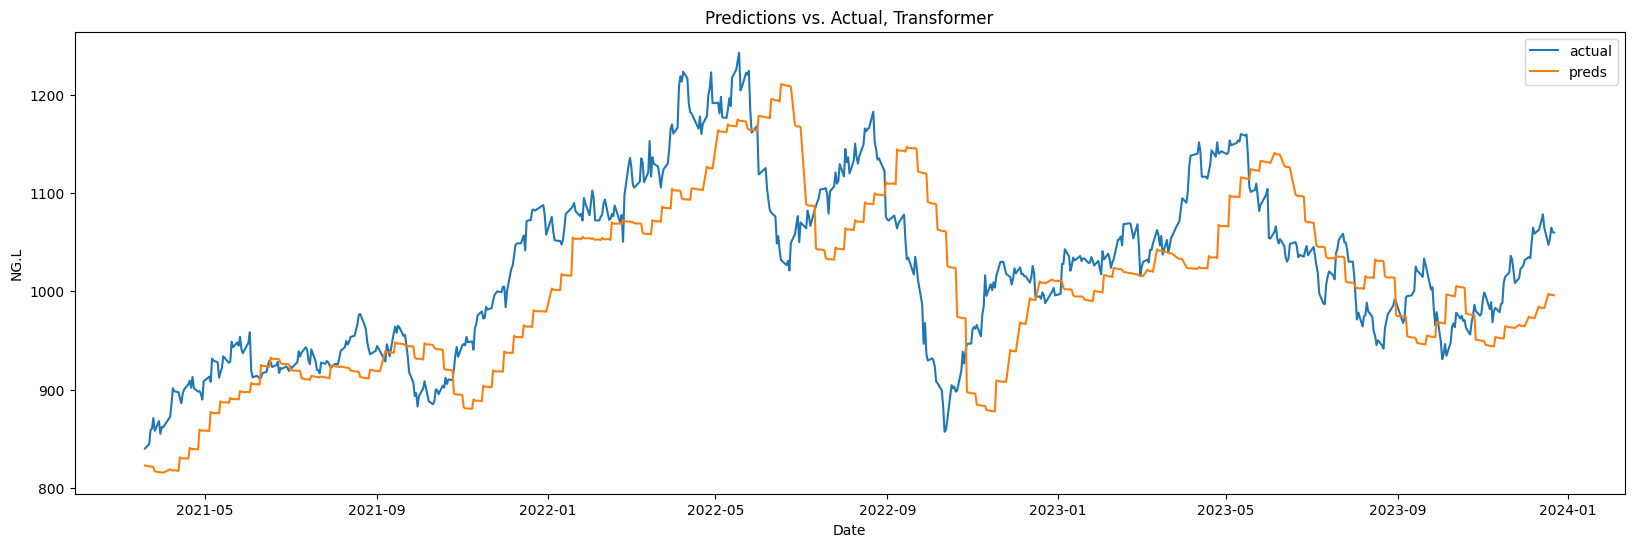

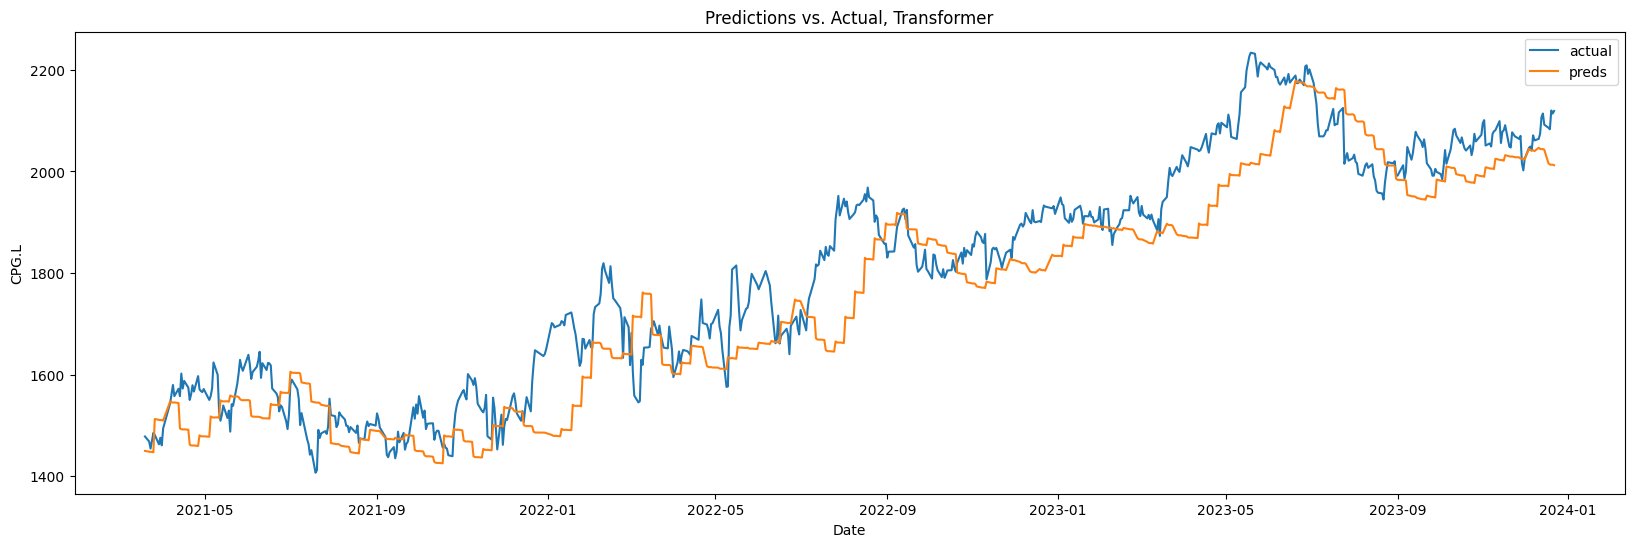

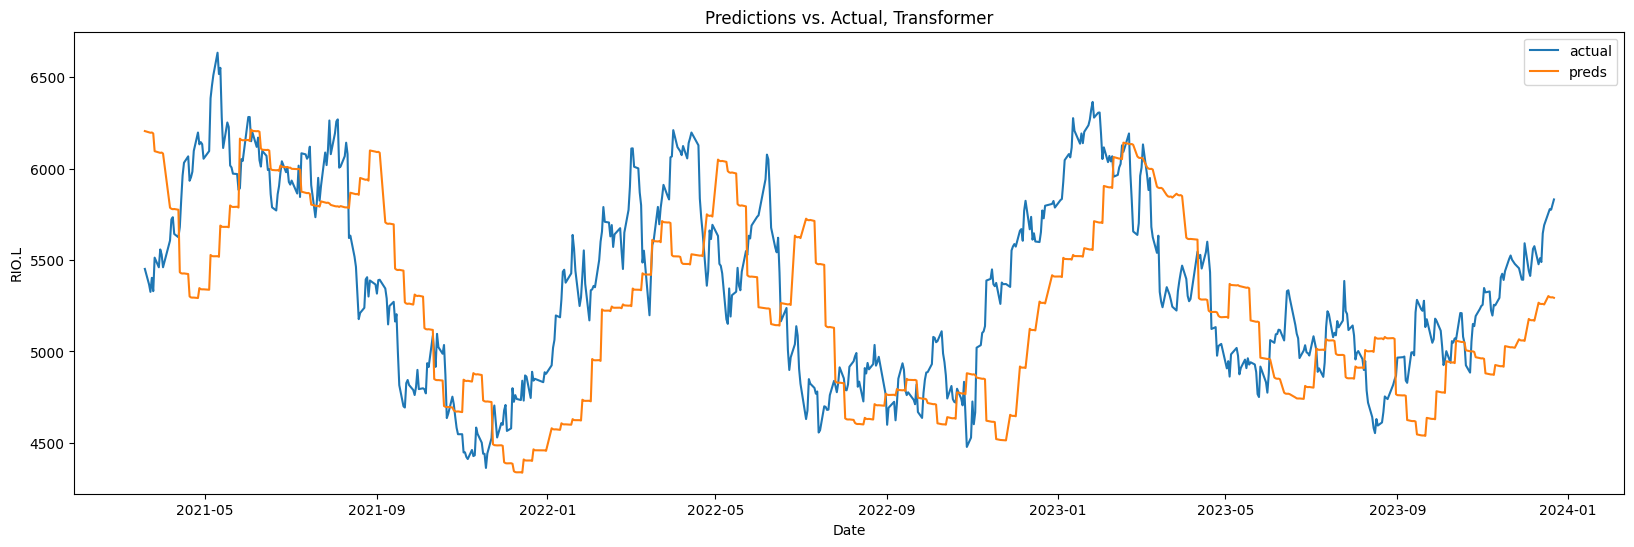

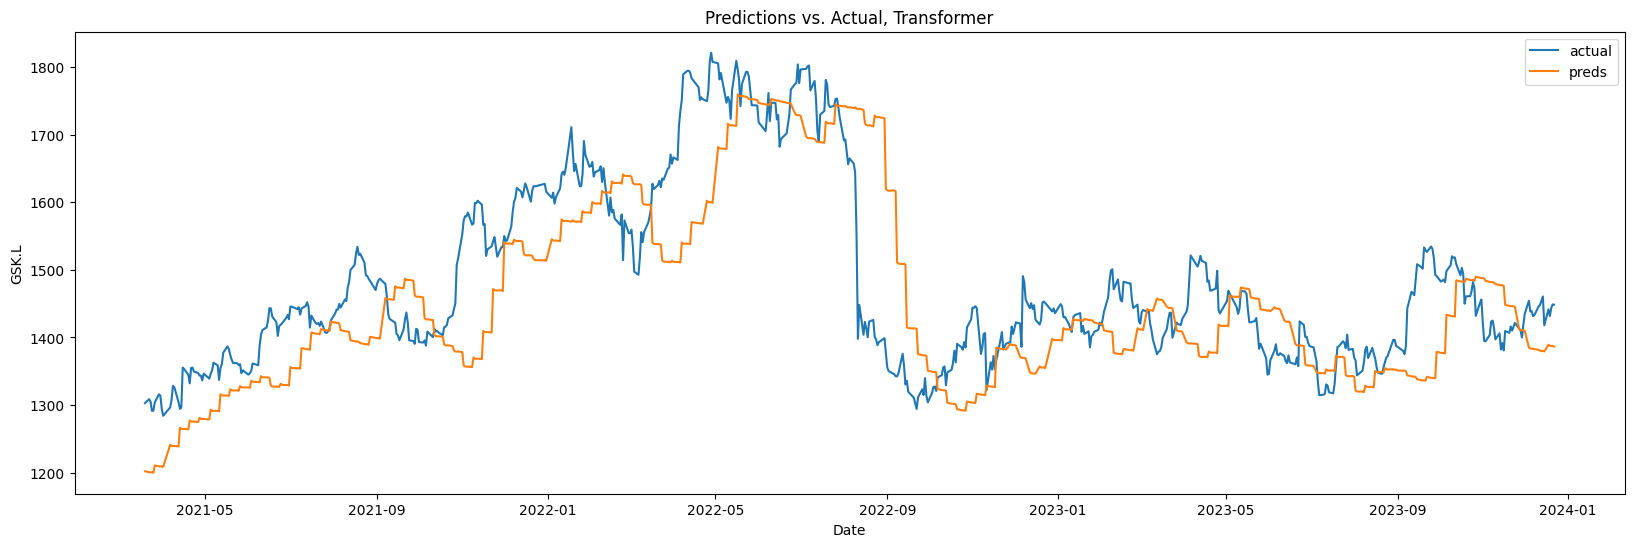

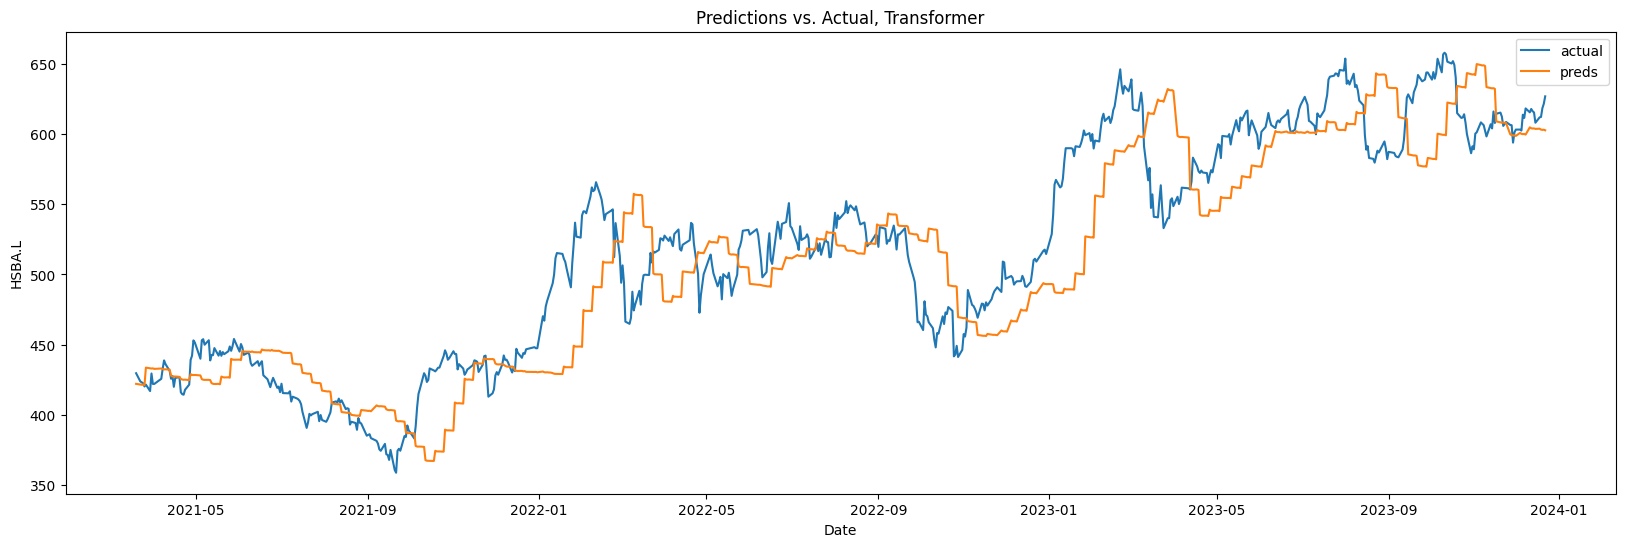

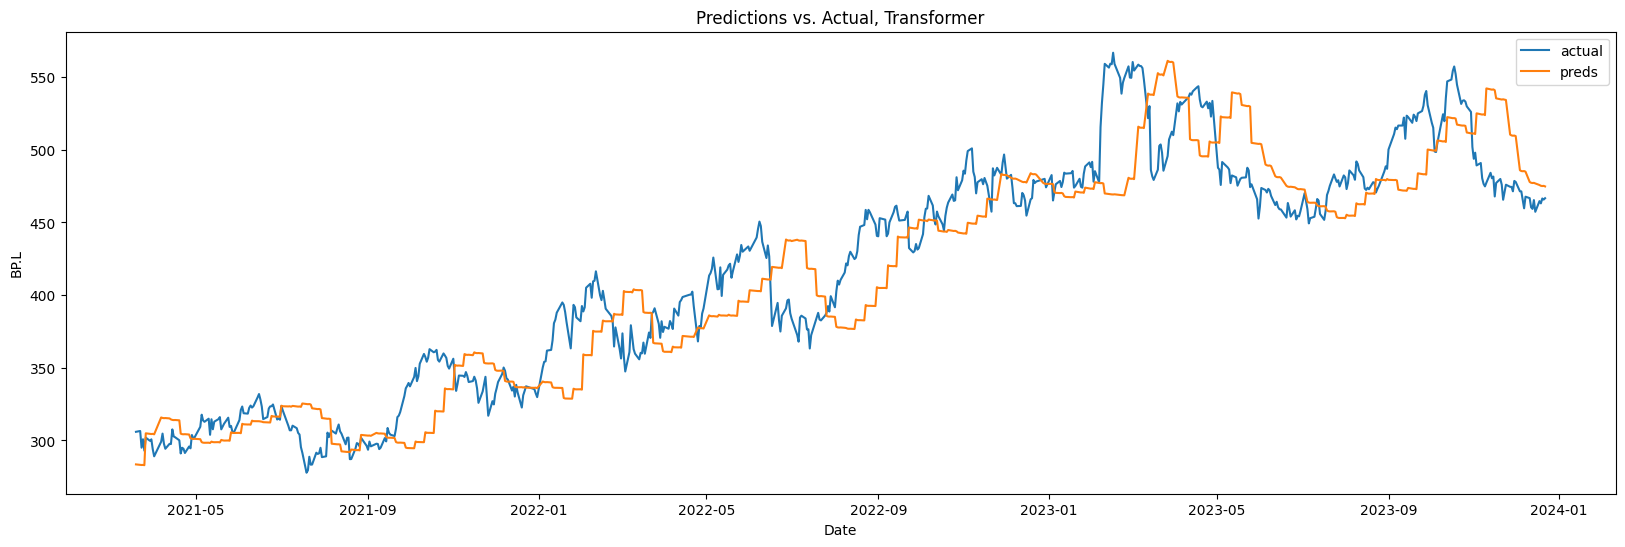

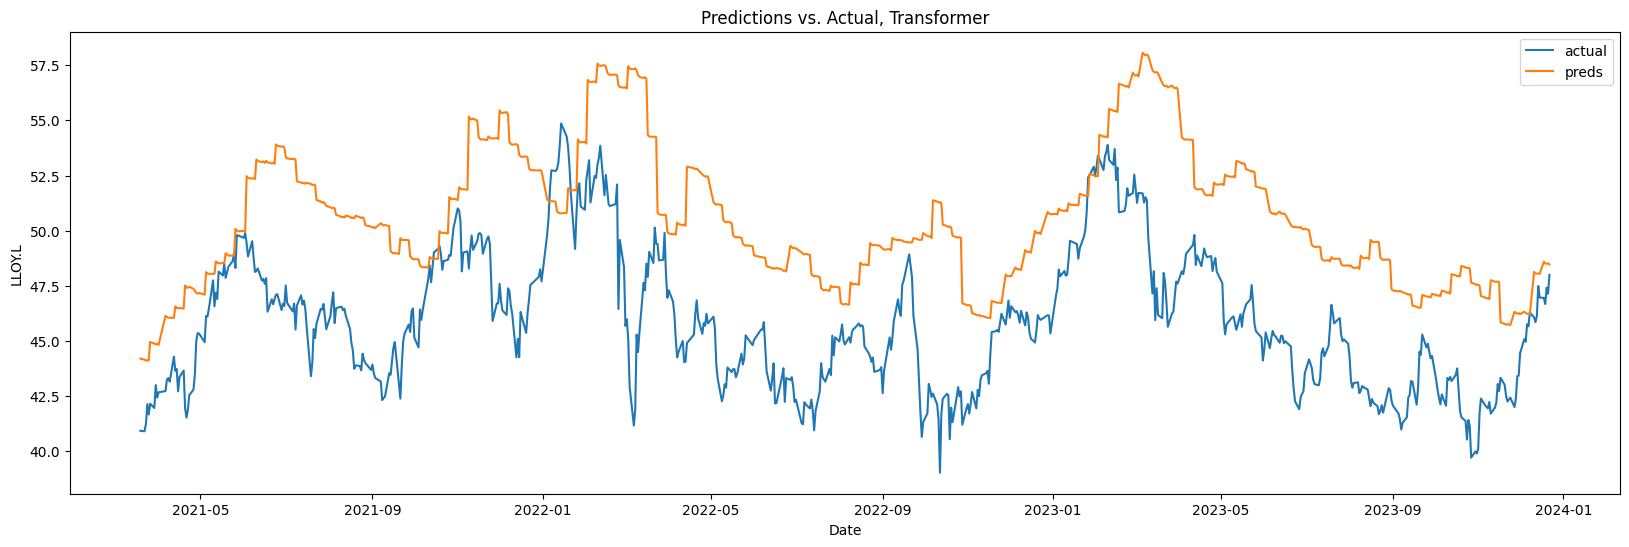

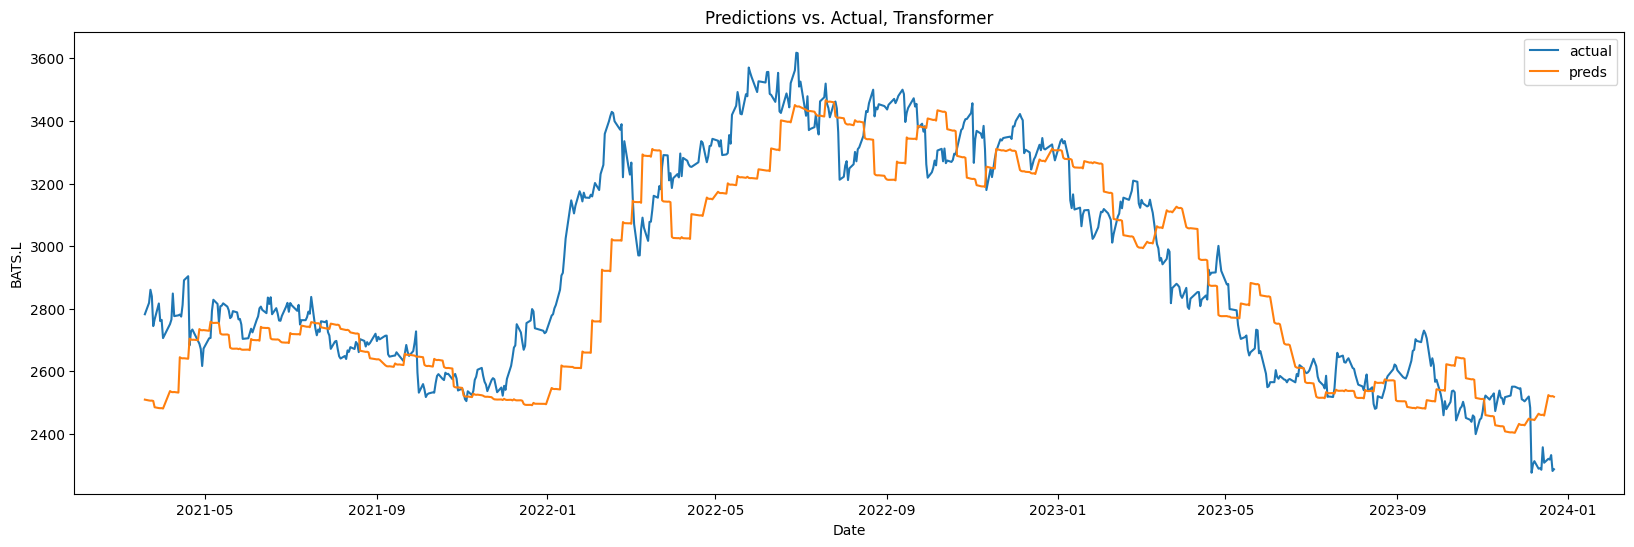

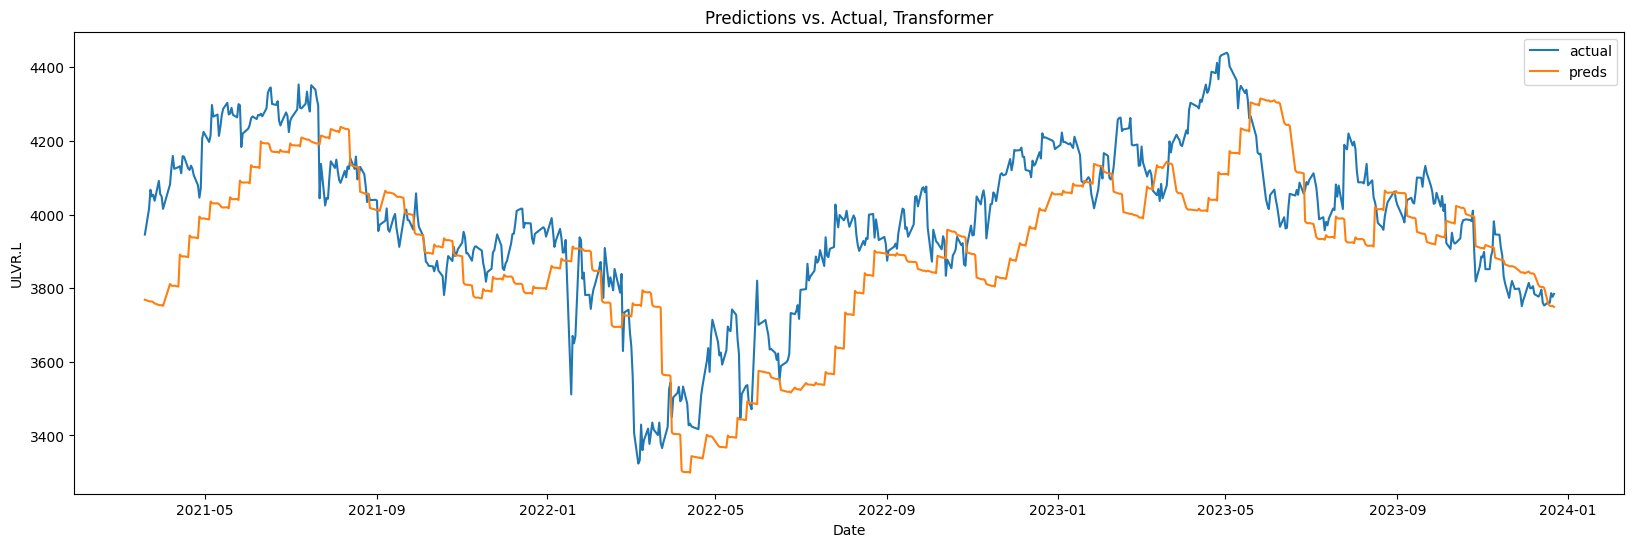

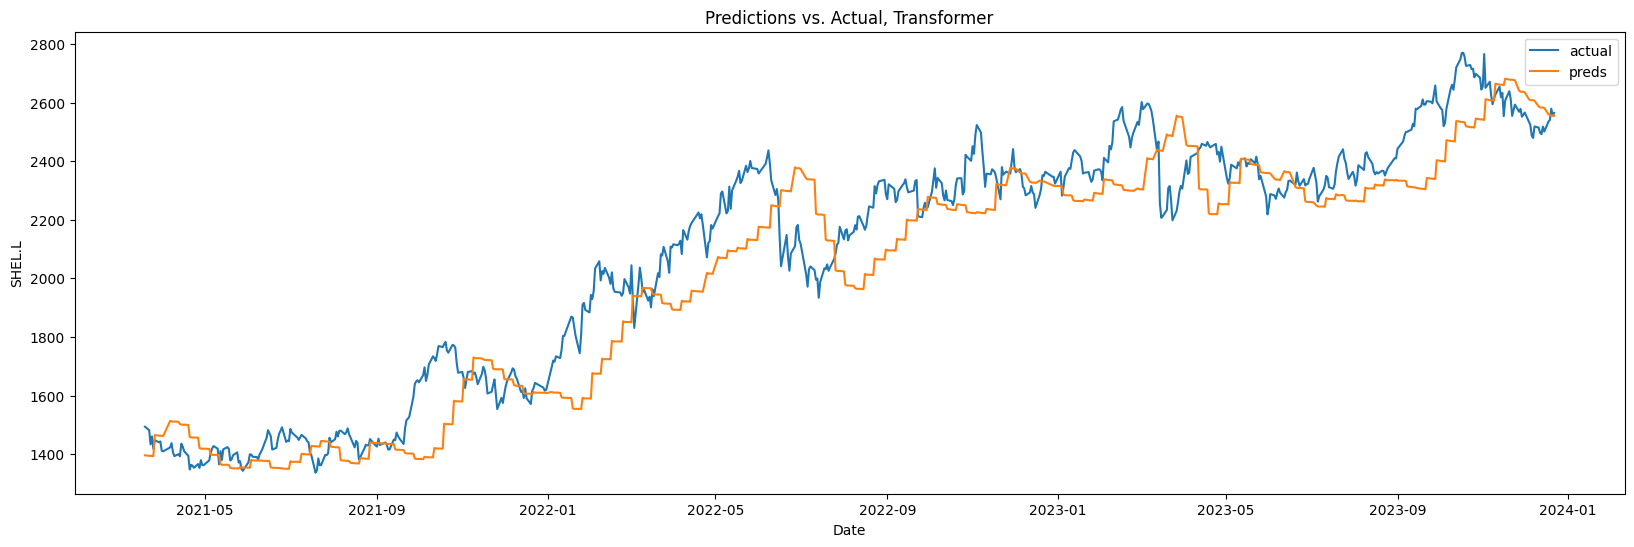

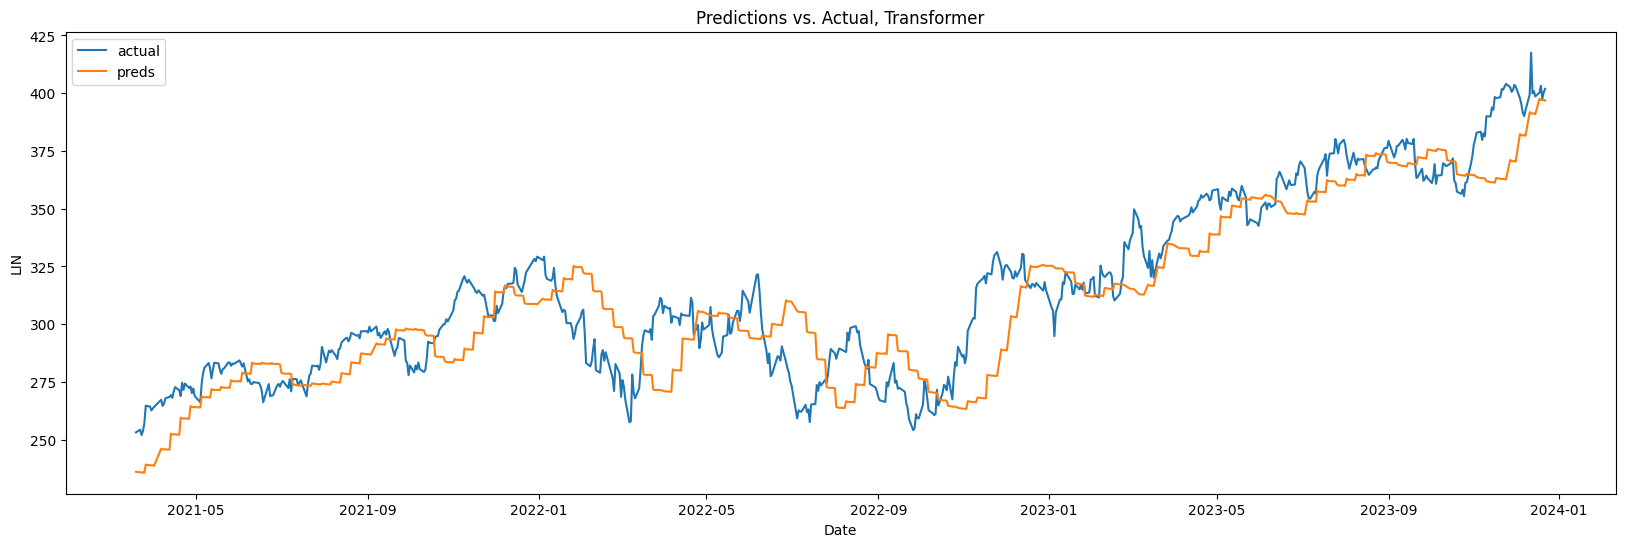

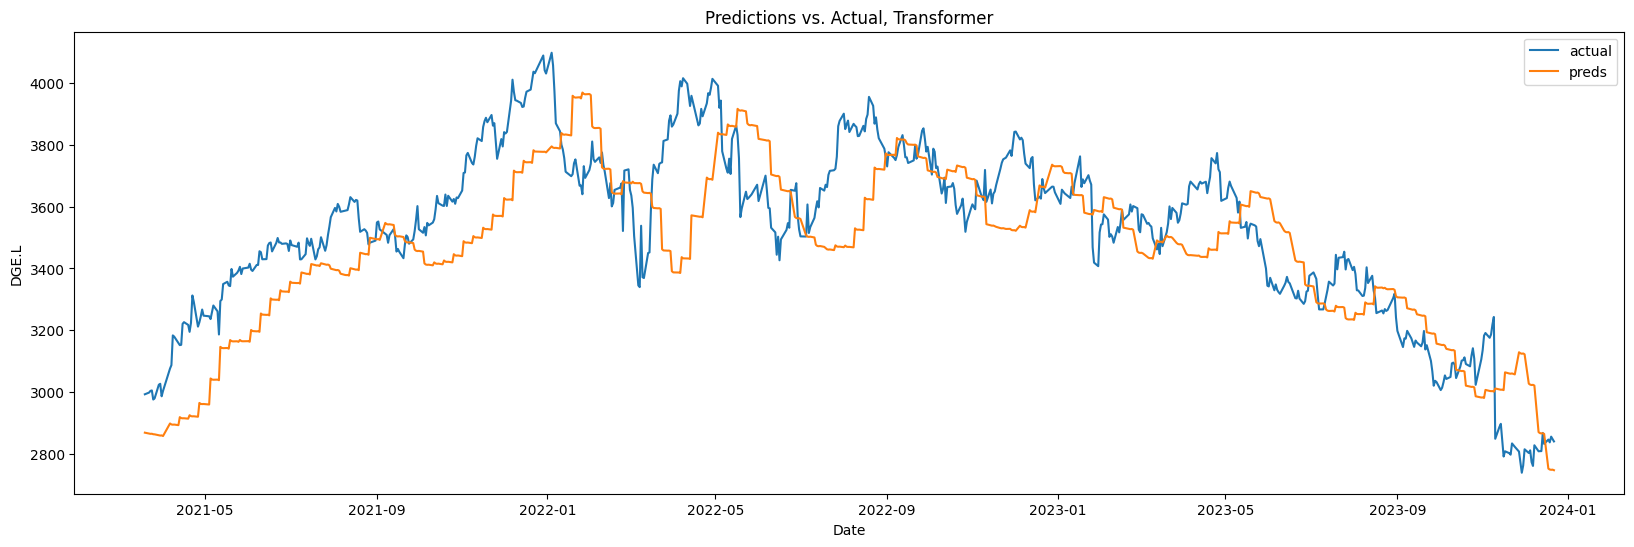

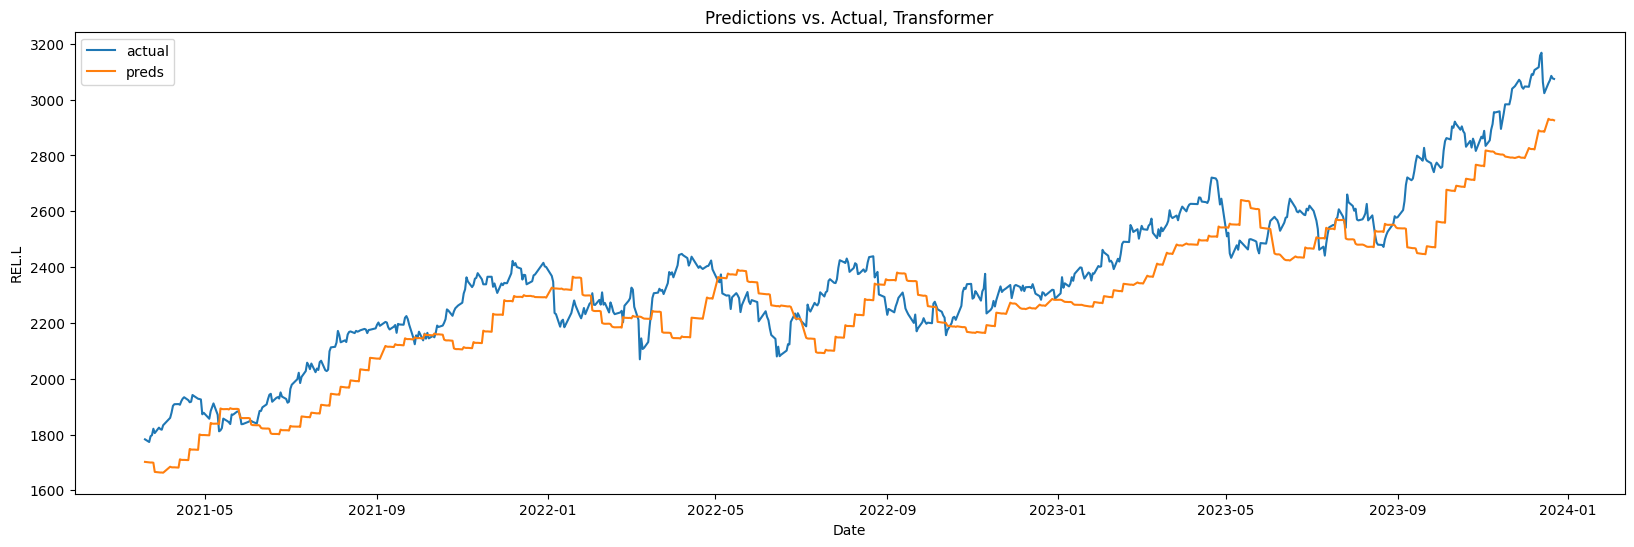

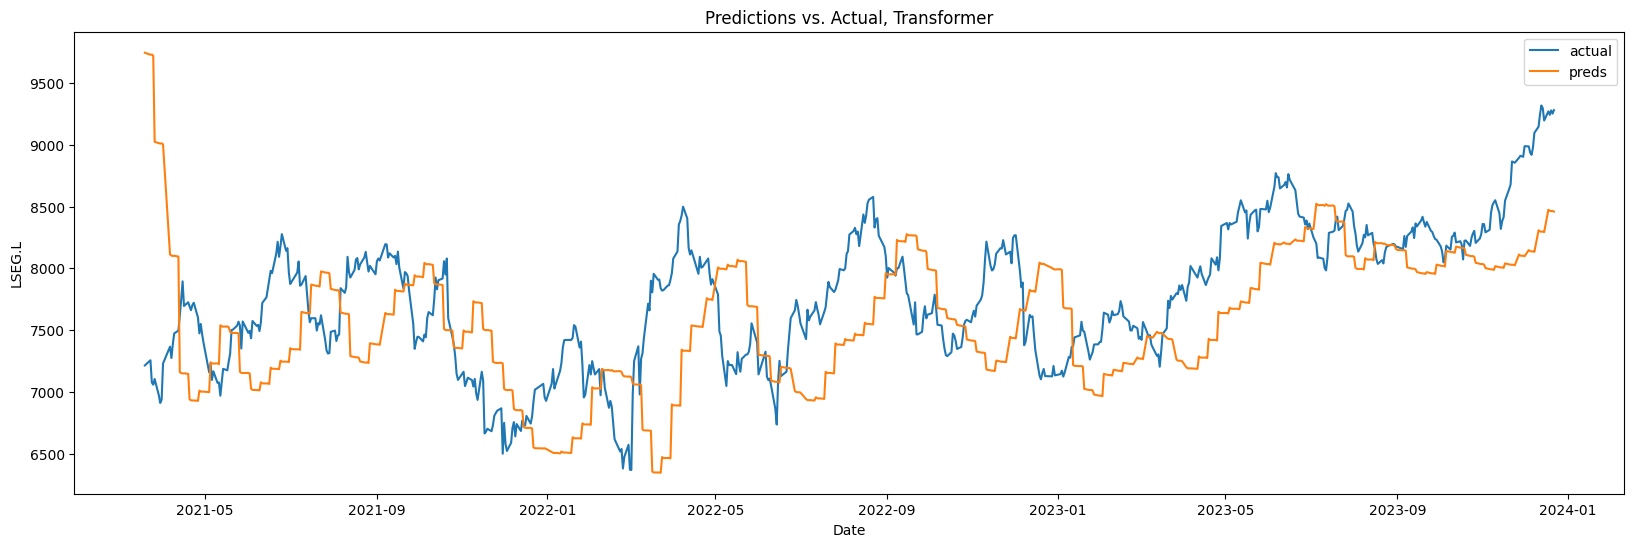

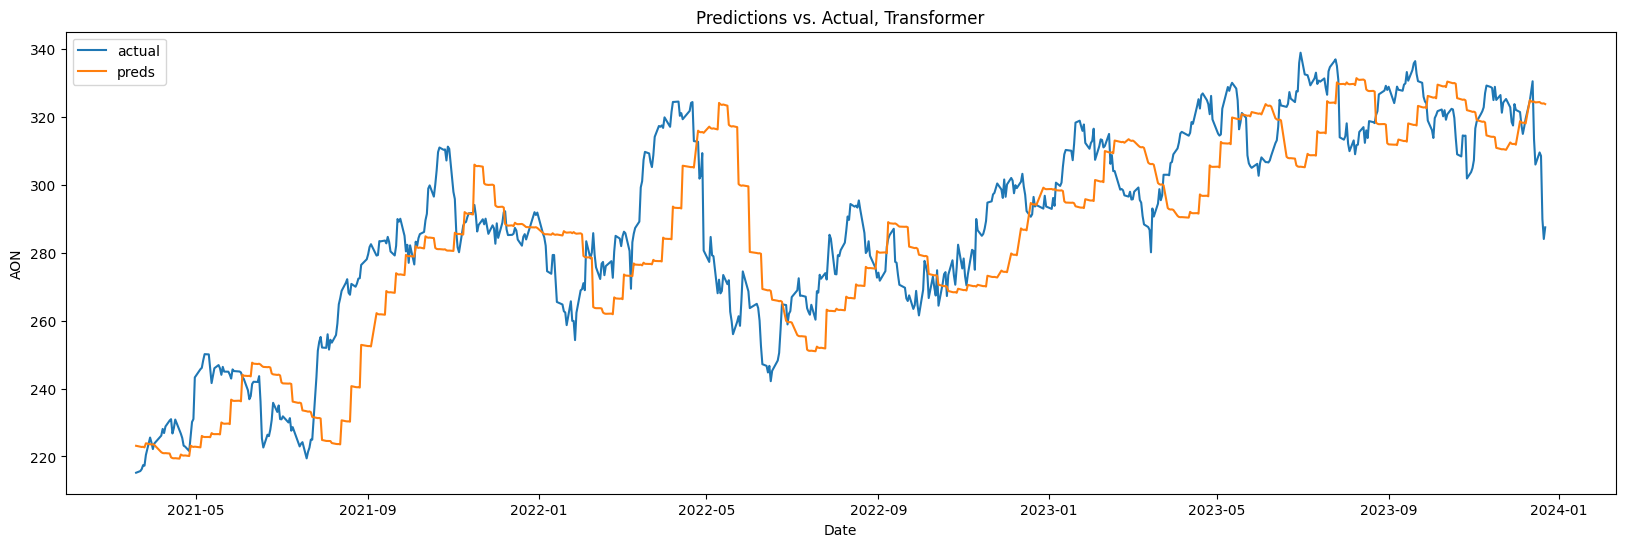

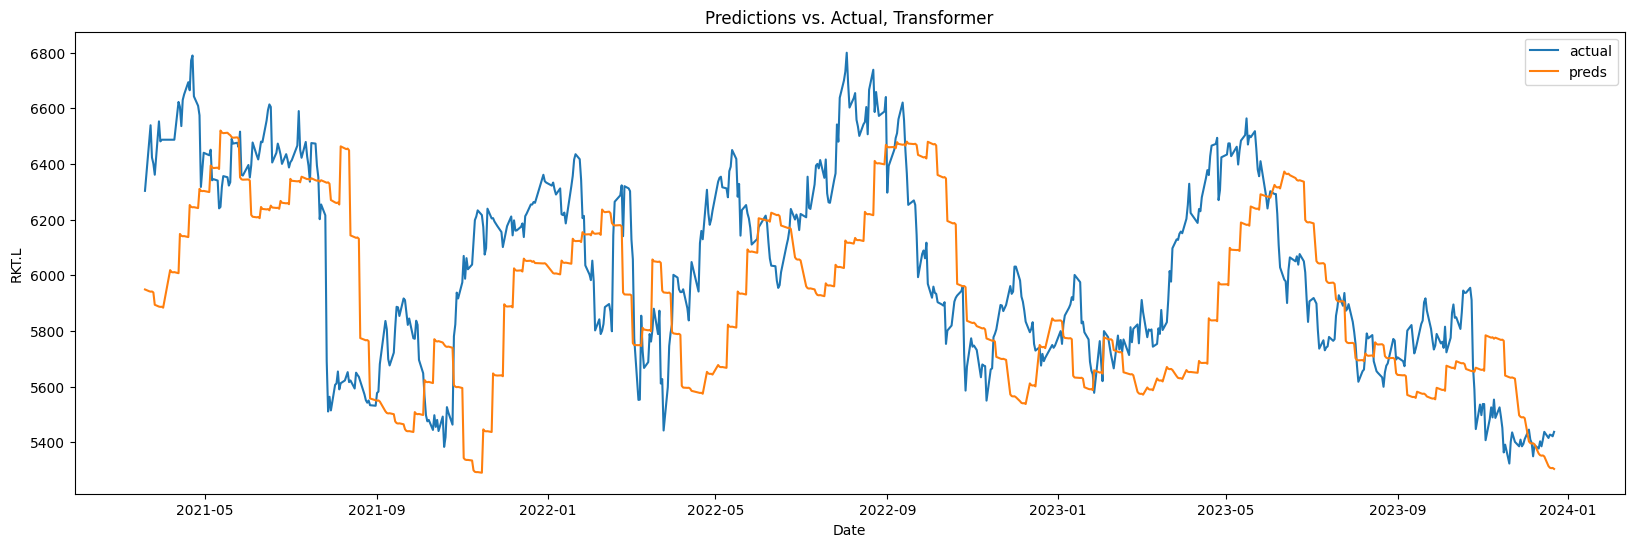

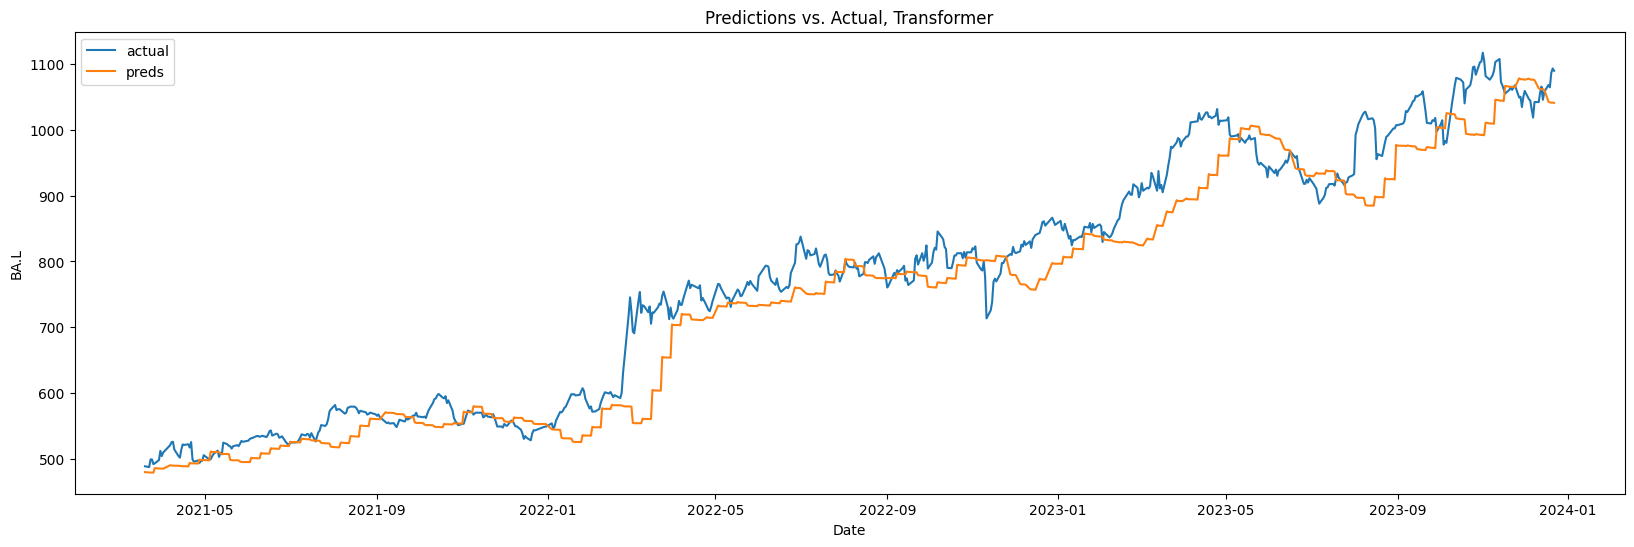

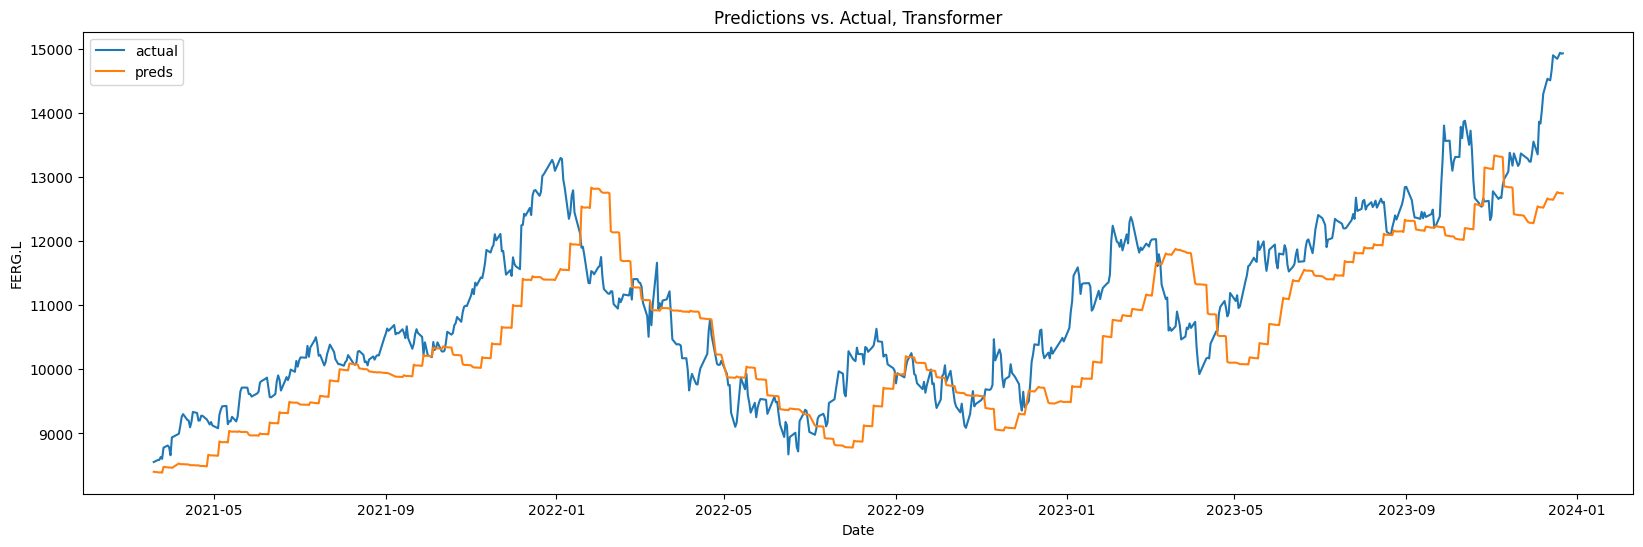

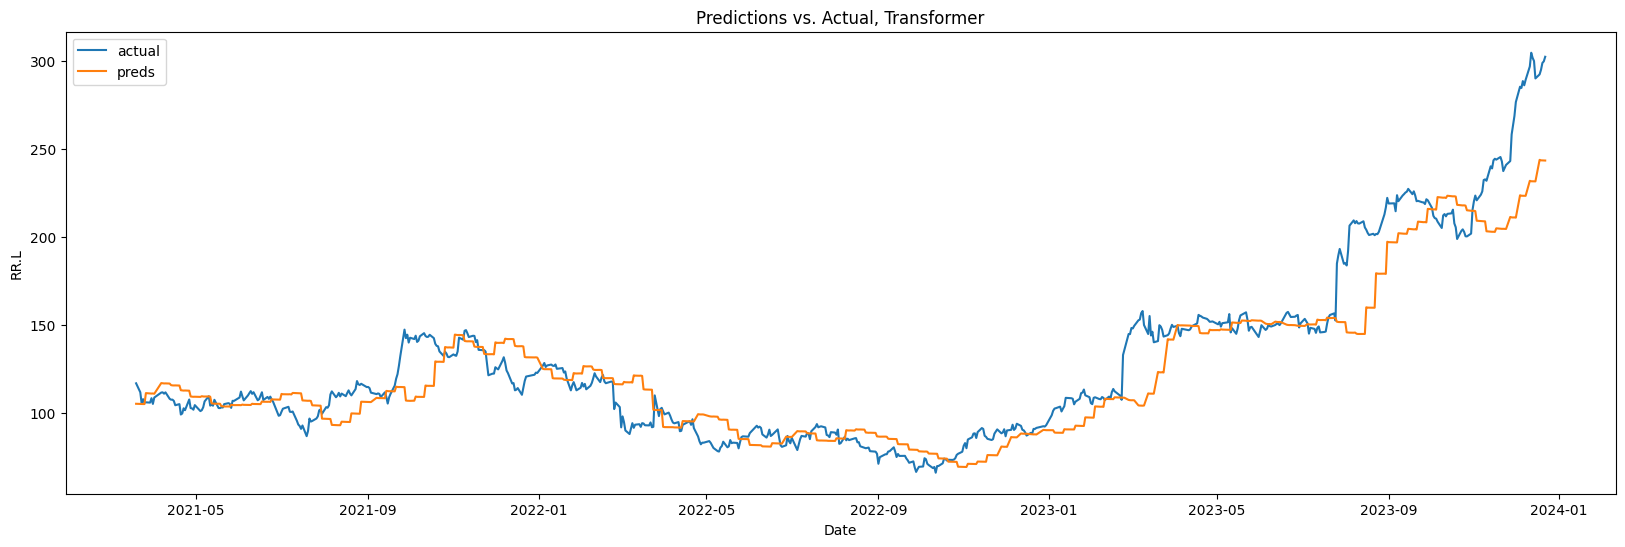

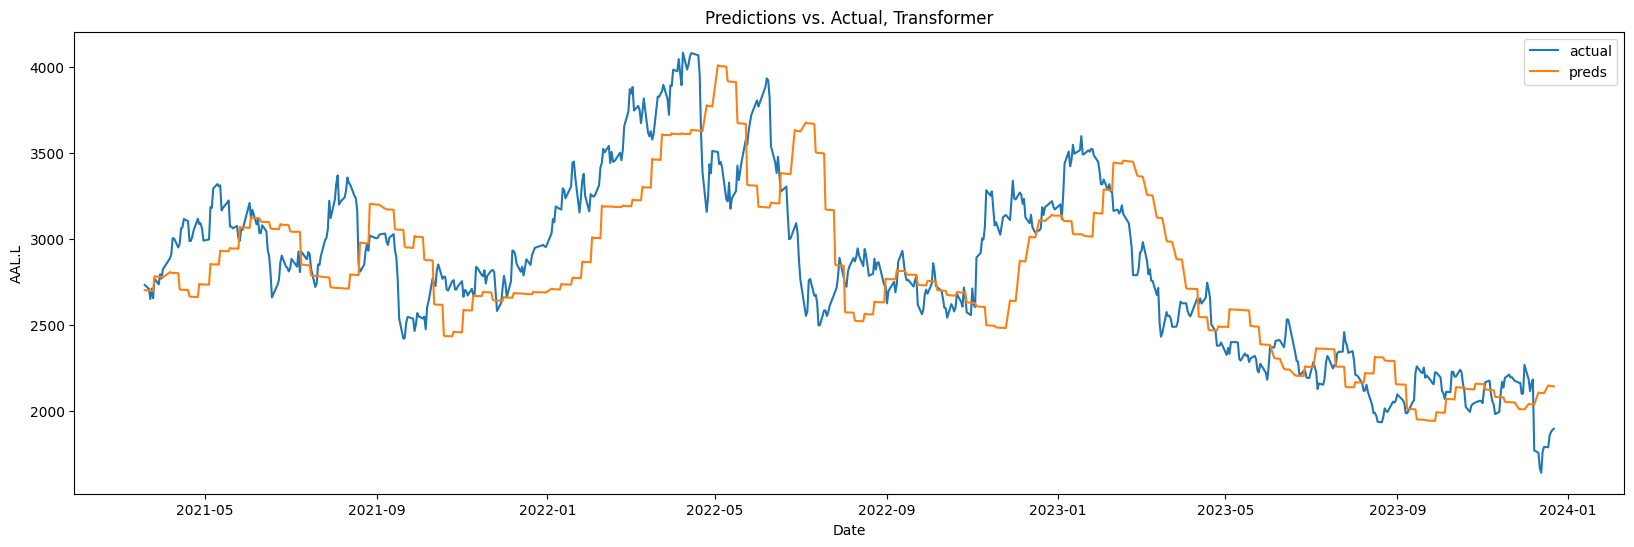

In [26]:
# Run your plotting loop
for i in range(len(data.ticker)):
    plot_results(test[i], predict[i].predictions, data.df[data.df.columns[i]],
                 title_suffix='Transformer', xlabel=data.df.columns[i],
                 image_name=data.ticker[i])

In [27]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

# Calculate Expected Returns based on the Model's Predictions
# We use the predicted prices to estimate the expected return vector (mu)
mu = mean_historical_return(predict_pd)

# Calculate the Covariance Matrix based on the Actual Test Data
# We use the actual historical (test) volatility to estimate risk (S)
S = CovarianceShrinkage(test_pd).ledoit_wolf()

# Optimize for the Maximum Sharpe Ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Display the results
print("Optimized Portfolio Weights (Max Sharpe):")
display(cleaned_weights)

print("\nPortfolio Performance:")
ef.portfolio_performance(verbose=True)

Optimized Portfolio Weights (Max Sharpe):


OrderedDict([('NG.L', 0.02923),
             ('CPG.L', 0.0265),
             ('RIO.L', 0.03748),
             ('GSK.L', 0.00676),
             ('HSBA.L', 0.05192),
             ('BP.L', 0.02557),
             ('LLOY.L', 0.01615),
             ('BATS.L', 0.0),
             ('ULVR.L', 0.0),
             ('SHEL.L', 0.06116),
             ('LIN', 0.06163),
             ('DGE.L', 0.0),
             ('REL.L', 0.10518),
             ('LSEG.L', 0.08827),
             ('AON', 0.01433),
             ('RKT.L', 0.0),
             ('BA.L', 0.16761),
             ('FERG.L', 0.09716),
             ('RR.L', 0.21104),
             ('AAL.L', 0.0)])


Portfolio Performance:
Expected annual return: 24.2%
Annual volatility: 11.7%
Sharpe Ratio: 2.07


(np.float64(0.24172557079997767),
 np.float64(0.11666565954861739),
 np.float64(2.0719513499963953))

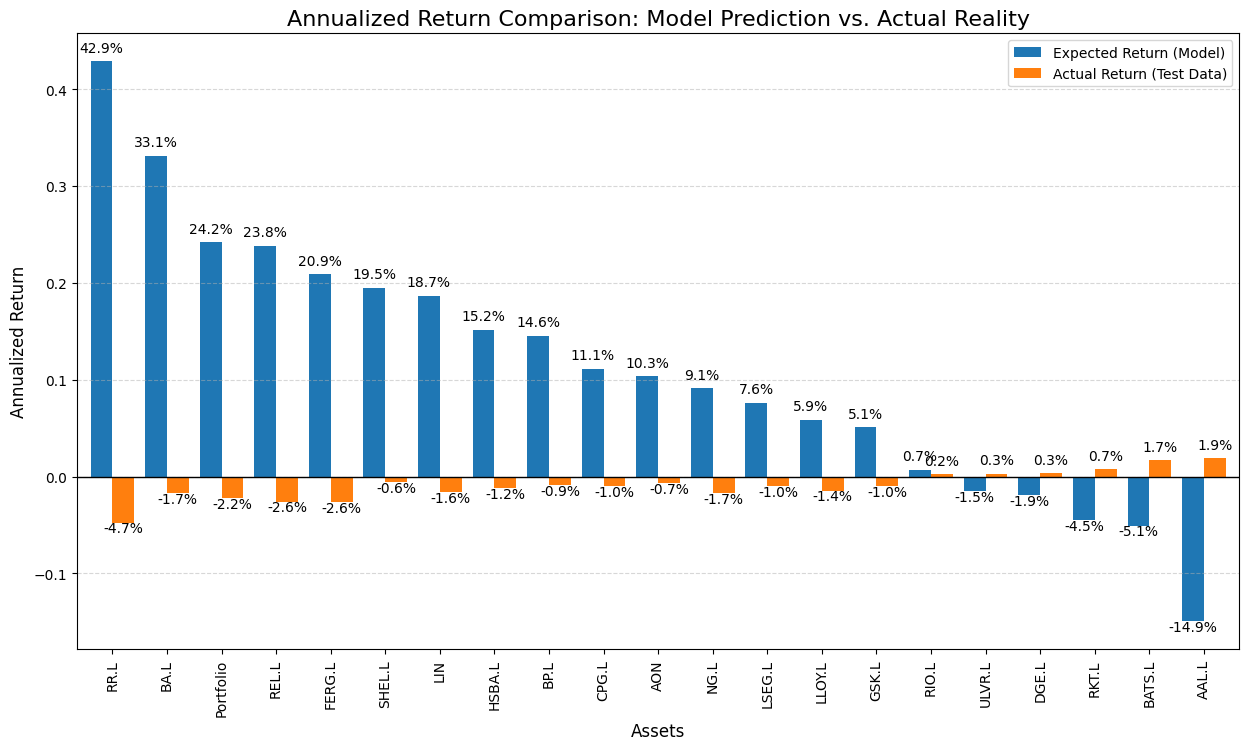

In [30]:
import matplotlib.pyplot as plt

# Prepare data for plotting
plot_df = comparison_df.copy()

# Add the final Portfolio aggregate to the plot data
plot_df.loc['Portfolio'] = [optimal_expected_return, optimal_actual_return, 0]

# Plotting
ax = plot_df[['Expected Return (Model)', 'Actual Return (Test Data)']].sort_values(by='Expected Return (Model)', ascending=False).plot(kind='bar', figsize=(15, 8), width=0.8)

plt.title('Annualized Return Comparison: Model Prediction vs. Actual Reality', fontsize=16)
plt.ylabel('Annualized Return', fontsize=12)
plt.xlabel('Assets', fontsize=12)
plt.axhline(0, color='black', linewidth=1)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add labels to the Portfolio bars for clarity
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height != 0:
        ax.annotate(f'{height:.1%}', (x + width/2, y + height + 0.01*np.sign(height)), ha='center')

plt.show()

In [29]:
import pandas as pd
import numpy as np
from pypfopt.expected_returns import mean_historical_return

# 1. Calculate Actual Returns for each asset using the Test Data
actual_returns = mean_historical_return(test_pd)

# 2. Compare Individual Assets (Expected vs Actual)
comparison_df = pd.DataFrame({
    'Expected Return (Model)': mu,
    'Actual Return (Test Data)': actual_returns
})
comparison_df['Difference'] = comparison_df['Actual Return (Test Data)'] - comparison_df['Expected Return (Model)']

print("--- Individual Asset Performance: Actual vs Expected ---")
display(comparison_df.sort_values(by='Actual Return (Test Data)', ascending=False))

# 3. Calculate Performance for the Optimized Portfolio
# We use the weights from the previous step (cleaned_weights)
# Note: cleaned_weights is a dictionary, we need to align it with the Series order

# Convert weights dictionary to a numpy array in the same order as actual_returns
weights_array = np.array([cleaned_weights.get(ticker, 0) for ticker in actual_returns.index])

# Calculate Actual Portfolio Return (Weighted Sum of Actual Asset Returns)
optimal_actual_return = np.sum(weights_array * actual_returns)
optimal_expected_return = performance[0] # From the previous cell output (approx 24.2%)

print("\n--- Optimized Portfolio Performance ---")
print(f"Expected Portfolio Return: {optimal_expected_return:.1%}")
print(f"Actual Portfolio Return:   {optimal_actual_return:.1%}")
print(f"Difference:                {optimal_actual_return - optimal_expected_return:.1%}")

--- Individual Asset Performance: Actual vs Expected ---


,Expected Return (Model),Actual Return (Test Data),Difference
AAL.L,-0.149385,0.018820,0.168204
BATS.L,-0.050709,0.016626,0.067335
RKT.L,-0.044670,0.007455,0.052125
DGE.L,-0.019294,0.003386,0.022681
ULVR.L,-0.015042,0.002757,0.017799
RIO.L,0.006850,0.002313,-0.004538
SHEL.L,0.195163,-0.005704,-0.200867
AON,0.103359,-0.006901,-0.110260
BP.L,0.145601,-0.008639,-0.154240
CPG.L,0.111424,-0.009673,-0.121097



--- Optimized Portfolio Performance ---
Expected Portfolio Return: 24.2%
Actual Portfolio Return:   -2.2%
Difference:                -26.4%


In [28]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier

# Re-instantiate the EfficientFrontier with the calculated mu and S to get the results
ef = EfficientFrontier(mu, S)

# Optimize for Maximum Sharpe Ratio
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Convert to a pandas Series for easy reading and sort by weight
weights_series = pd.Series(cleaned_weights).sort_values(ascending=False)

# Display assets with non-zero allocation
print("Recommended Portfolio Allocation (Max Sharpe):")
display(weights_series[weights_series > 0])

print("\nPortfolio Performance Summary:")
performance = ef.portfolio_performance(verbose=True)

Recommended Portfolio Allocation (Max Sharpe):


,0
RR.L,0.21104
BA.L,0.16761
REL.L,0.10518
FERG.L,0.09716
LSEG.L,0.08827
LIN,0.06163
SHEL.L,0.06116
HSBA.L,0.05192
RIO.L,0.03748
NG.L,0.02923



Portfolio Performance Summary:
Expected annual return: 24.2%
Annual volatility: 11.7%
Sharpe Ratio: 2.07
